# PyTorch: Regression and Classification 

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, preprocessing

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [3]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
device

device(type='cpu')

## Tabular Data Regression

### Load and Process Data

In [4]:
boston = datasets.load_boston()
features = boston["data"]
feature_names = boston["feature_names"]
number_of_features = len(feature_names)
labels = boston["target"]

In [5]:
df = pd.DataFrame(features)
df.columns = feature_names 
df["LABEL"] = labels

In [6]:
X = df.drop(columns=["LABEL"])
y = df["LABEL"]

In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)

In [8]:
scaler = preprocessing.StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_validation_standardized = scaler.transform(X_validation)

### Datasets and Dataloaders

In [9]:
class MyDataset(Dataset):
    def __init__(self, input_X, input_y, device):
        self.X = torch.tensor(input_X, dtype=torch.float, device=device)
        self.y = torch.tensor(input_y.values, dtype=torch.float, device=device).view(-1,1)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, index):
        each_X = self.X[index]
        each_y = self.y[index]
        return each_X, each_y

In [10]:
training_dataset = MyDataset(X_train_standardized, y_train, device)
validation_dataset = MyDataset(X_validation_standardized, y_validation, device)

In [11]:
params = {
    "batch_size" : 100,
    "shuffle" : True,
}

In [12]:
training_dataloader = DataLoader(training_dataset, **params)
validation_dataloader = DataLoader(validation_dataset, **params)

### Model

In [13]:
# simple feed-forward fully connected ANN
class MySimpleNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Training Loop

In [14]:
def training_loop(n_epochs, model, optimizer, loss_fn, training_dl, validation_dl):
    
    # epochs 
    loss_train_epoch = []
    loss_val_epoch = []
    for epoch in range(1, n_epochs+1):
        
        # training 
        loss_train = 0.0
        loss_train_n = 0
        model.train()
        for train_X, train_y in training_dl:
            # model
            train_predict_y = model(train_X)
            # loss
            loss = loss_fn(train_predict_y, train_y)
            # machine learning
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # loss
            loss_train += loss.item()
            loss_train_n += len(train_y)
        loss_train_avg = loss_train / loss_train_n
        loss_train_epoch.append(loss_train_avg)
            
        # validation
        loss_val = 0.0
        loss_val_n = 0
        model.eval()
        with torch.no_grad():
            for val_X, val_y in validation_dl:
                # model
                val_predict_y = model(val_X)
                # loss
                loss = loss_fn(val_predict_y, val_y)
                loss_val += loss.item()
                loss_val_n += len(val_y)
            loss_val_avg = loss_val / loss_val_n
            loss_val_epoch.append(loss_val_avg)

        # tensorboard
        writer.add_scalar("Loss/Training", loss_train_avg, epoch)
        writer.add_scalar("Loss/Validation", loss_val_avg, epoch)
        
        # status messages
        if (epoch == 1) or (epoch/n_epochs in np.arange(0.1,1.1,0.1)):
            print(f"Epoch {epoch}: Train Loss: {loss_train_avg:.5f}, Val Loss {loss_val_avg:.5f}")
            
    # tensorboard  
    writer.close() 
    
    # learning curves
    plt.figure(figsize=[10,7])
    df_plot = pd.DataFrame({"train" : loss_train_epoch, "val" : loss_val_epoch})
    plt.plot(df_plot)
    plt.title("Learning Curves")
    plt.legend(["Training", "Validation"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

In [15]:
# tensorboard
# run via terminal: "tensorboard --logdir=runs"
# access via http://localhost:6006/
writer = SummaryWriter()

Epoch 1: Train Loss: 6.89132, Val Loss 6.81416
Epoch 25: Train Loss: 6.47903, Val Loss 11.80986
Epoch 50: Train Loss: 2.83611, Val Loss 3.59074
Epoch 100: Train Loss: 0.26352, Val Loss 0.42274
Epoch 125: Train Loss: 0.20345, Val Loss 0.39147
Epoch 150: Train Loss: 0.19774, Val Loss 0.28795
Epoch 200: Train Loss: 0.16081, Val Loss 0.22073
Epoch 225: Train Loss: 0.26177, Val Loss 0.24904
Epoch 250: Train Loss: 0.16314, Val Loss 0.44087


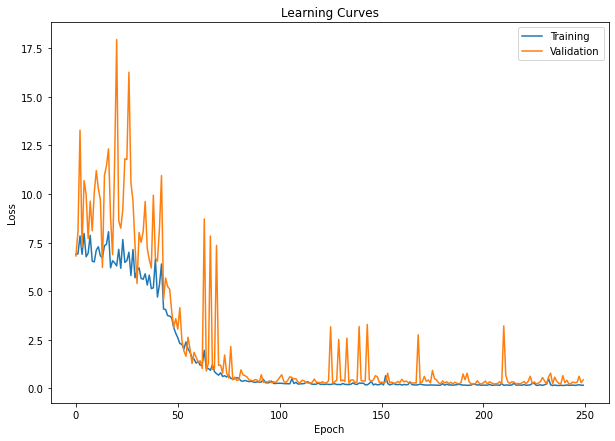

In [16]:
model = MySimpleNN(number_of_features)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
training_loop(
    n_epochs=250, 
    model=model, 
    optimizer=optimizer,
    loss_fn=nn.MSELoss(),
    training_dl=training_dataloader, 
    validation_dl=validation_dataloader,
)

### Predictions

In [17]:
predictions = model(torch.tensor(X_validation_standardized).float()).detach().numpy().flatten()
df_predictions = pd.DataFrame({"y" : y_validation, "y-hat" : predictions})
df_predictions_sorted = df_predictions.sort_values(by='y').reset_index(drop=True)

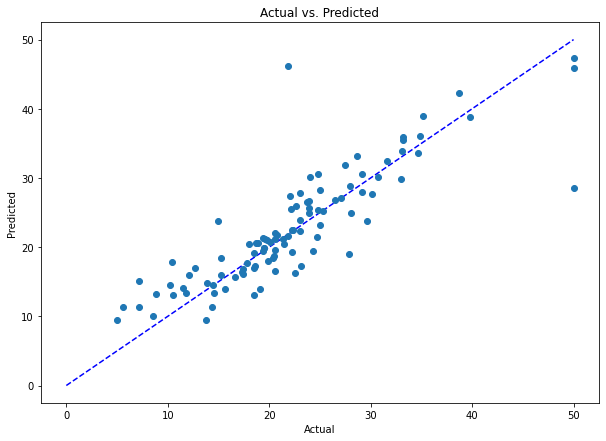

In [18]:
plt.figure(figsize=[10,7])
plt.plot((0, df_predictions.max().max()), (0, df_predictions.max().max()), 'b--')
plt.plot(df_predictions["y"], df_predictions['y-hat'], 'o')
plt.title("Actual vs. Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

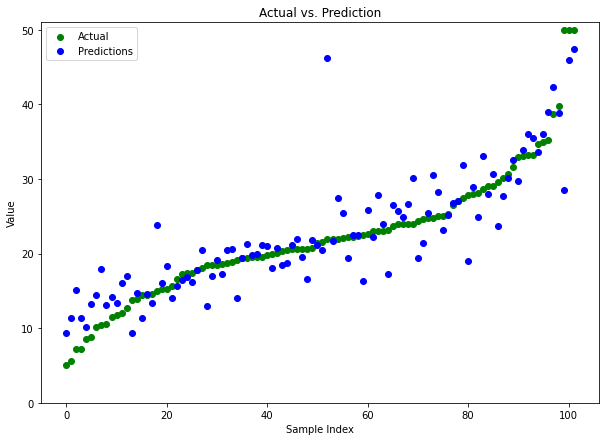

In [19]:
plt.figure(figsize=[10,7])
plt.scatter(df_predictions_sorted.index,
            df_predictions_sorted["y"],
            color='green')
plt.errorbar(df_predictions_sorted.index,
             df_predictions_sorted["y-hat"],
             ecolor='lightblue', 
             fmt='bo',
             elinewidth=0)
plt.title("Actual vs. Prediction")
plt.legend(['Actual','Predictions'])
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.ylim([0,df_predictions.max().max()+1])
plt.show()

## Image Classification

### Load and Process Data

In [20]:
digits = datasets.load_digits()
images = digits["images"]
image_size = images.shape[1:3]
number_of_channels = 1
labels = digits["target"]

In [21]:
images = images / 16.0

In [22]:
X_train, X_validation, y_train, y_validation = train_test_split(images, labels, test_size=0.2)

### Datasets and Dataloaders

In [23]:
class MyImageDataset(Dataset):
    def __init__(self, input_X, input_y, device):
        self.X = torch.tensor(input_X, dtype=torch.float, device=device).unsqueeze(1)
        self.y = torch.tensor(input_y, dtype=torch.long, device=device)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, index):
        each_X = self.X[index]
        each_y = self.y[index]
        return each_X, each_y

In [24]:
training_dataset = MyImageDataset(X_train, y_train, device)
validation_dataset = MyImageDataset(X_validation, y_validation, device)

In [25]:
params = {
    "batch_size" : 256,
    "shuffle" : True,
}

In [26]:
training_dataloader = DataLoader(training_dataset, **params)
validation_dataloader = DataLoader(validation_dataset, **params)

### Model

In [34]:
# simple 2D CNN with dropout and max pooling 
class MySimpleCNN(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 10, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=2, padding=1)
        self.dropout_conv1 = nn.Dropout2d(0.1)
        self.dropout_conv2 = nn.Dropout2d(0.1)
        self.fc1 = nn.Linear(80, 100)
        self.fc2 = nn.Linear(100, 10)
        self.dropout_fc1 = nn.Dropout(0.1)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = self.dropout_conv1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.dropout_conv2(x)
        x = x.view(-1, 80)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

### Training Loop

In [38]:
def training_loop(n_epochs, model, optimizer, loss_fn, training_dl, validation_dl):
    
    # epochs 
    loss_train_epoch = []
    loss_val_epoch = []
    correct_train_epoch = []
    correct_val_epoch = []
    for epoch in range(1, n_epochs+1):
        
        # training 
        loss_train = 0.0
        loss_train_n = 0
        correct_train = 0
        correct_train_n = 0
        model.train()
        for train_X, train_y in training_dl:
            # model
            train_predict_y = model(train_X)           
            train_predict_y_class = torch.argmax(train_predict_y, axis=1)
            # loss
            loss = loss_fn(train_predict_y, train_y)
            # machine learning
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # loss and accuracy 
            loss_train += loss.item()
            loss_train_n += len(train_y)
            correct = train_predict_y_class == train_y
            correct_train += sum(correct)
            correct_train_n += len(correct)       
        loss_train_avg = loss_train / loss_train_n
        loss_train_epoch.append(loss_train_avg)
        correct_train_avg = correct_train / correct_train_n
        correct_train_epoch.append(correct_train_avg)
            
        # validation
        loss_val = 0.0
        loss_val_n = 0
        correct_val = 0
        correct_val_n = 0
        model.eval()
        with torch.no_grad():
            for val_X, val_y in validation_dl:
                # model
                val_predict_y = model(val_X)
                val_predict_y_class = torch.argmax(val_predict_y, axis=1)
                # loss and accuracy
                loss = loss_fn(val_predict_y, val_y)
                loss_val += loss.item()
                loss_val_n += len(val_y)
                correct = val_predict_y_class == val_y
                correct_val += sum(correct)
                correct_val_n += len(correct)   
            loss_val_avg = loss_val / loss_val_n
            loss_val_epoch.append(loss_val_avg)
            correct_val_avg = correct_val / correct_val_n
            correct_val_epoch.append(correct_val_avg)
            
        # tensorboard
        writer.add_scalar("Loss/Training", loss_train_avg, epoch)
        writer.add_scalar("Loss/Validation", loss_val_avg, epoch)
        writer.add_scalar("Accuracy/Training", correct_train_avg, epoch)
        writer.add_scalar("Accuracy/Validation", correct_val_avg, epoch)
        
        # status messages
        if (epoch == 1) or (epoch/n_epochs in np.arange(0.1,1.1,0.1)):
            print(f"Epoch {epoch}: Train Loss: {loss_train_avg:.5f}, Val Loss {loss_val_avg:.5f}")
            print(f"Epoch {epoch}: Train Accuracy: {correct_train_avg:.5f}, Val Accuracy {correct_val_avg:.5f}")

    # tensorboard  
    writer.close()
    
    # learning curves
    plt.figure(figsize=[10,7])
    df_learning_plot = pd.DataFrame({"train" : loss_train_epoch, "val" : loss_val_epoch})
    plt.plot(df_learning_plot)
    plt.title("Learning Curves")
    plt.legend(["Training", "Validation"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
    # accuracy curves
    plt.figure(figsize=[10,7])
    df_accuracy_plot = pd.DataFrame({"train" : correct_train_epoch, "val" : correct_val_epoch})
    plt.plot(df_accuracy_plot)
    plt.title("Accuracy Curves")
    plt.legend(["Training", "Validation"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

In [39]:
writer = SummaryWriter()

Epoch 1: Train Loss: 0.00961, Val Loss 0.01279
Epoch 1: Train Accuracy: 0.09743, Val Accuracy 0.10833
Epoch 200: Train Loss: 0.00961, Val Loss 0.01279
Epoch 200: Train Accuracy: 0.10160, Val Accuracy 0.08889
Epoch 400: Train Loss: 0.00956, Val Loss 0.01273
Epoch 400: Train Accuracy: 0.12387, Val Accuracy 0.10833
Epoch 800: Train Loss: 0.00686, Val Loss 0.00907
Epoch 800: Train Accuracy: 0.82881, Val Accuracy 0.82222
Epoch 1000: Train Loss: 0.00673, Val Loss 0.00904
Epoch 1000: Train Accuracy: 0.85456, Val Accuracy 0.83611
Epoch 1200: Train Loss: 0.00664, Val Loss 0.00889
Epoch 1200: Train Accuracy: 0.87196, Val Accuracy 0.85556
Epoch 1600: Train Loss: 0.00657, Val Loss 0.00885
Epoch 1600: Train Accuracy: 0.89353, Val Accuracy 0.86111
Epoch 1800: Train Loss: 0.00654, Val Loss 0.00881
Epoch 1800: Train Accuracy: 0.89562, Val Accuracy 0.86667
Epoch 2000: Train Loss: 0.00654, Val Loss 0.00882
Epoch 2000: Train Accuracy: 0.89770, Val Accuracy 0.87222


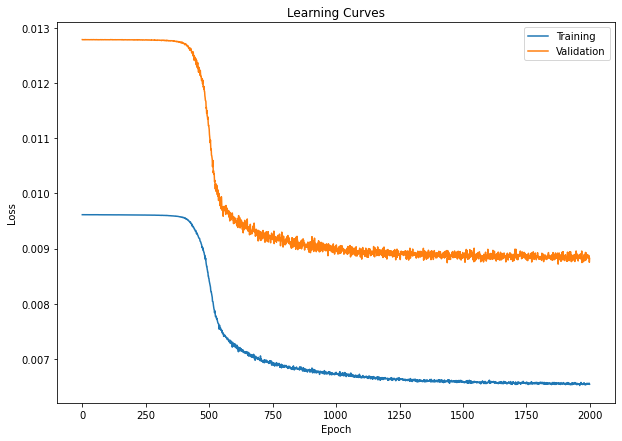

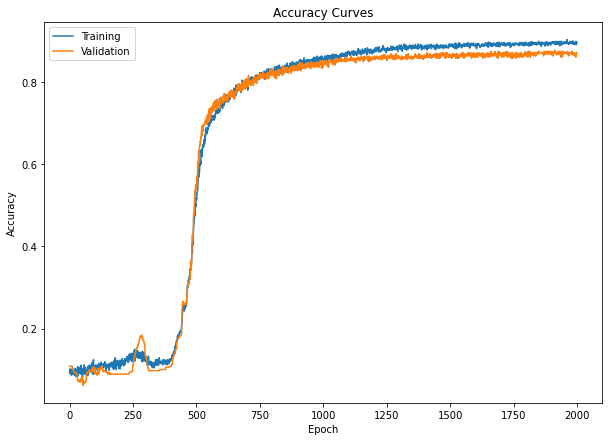

In [40]:
model = MySimpleCNN(number_of_channels)
optimizer = optim.SGD(model.parameters(), lr=0.1)
training_loop(
    n_epochs=2000, 
    model=model, 
    optimizer=optimizer,
    loss_fn=nn.CrossEntropyLoss(),
    training_dl=training_dataloader, 
    validation_dl=validation_dataloader,
)

### Predictions

In [41]:
predictions_prob = model(torch.tensor(X_validation).unsqueeze(1).float()).detach().numpy()
predictions_class = np.argmax(predictions_prob, axis=1)

In [42]:
df_predictions = pd.DataFrame({"y" : y_validation, "y-hat" : predictions_class})

In [43]:
accuracy = sum(df_predictions["y"] == df_predictions["y-hat"]) / df_predictions.shape[0] * 100
print(f"Validation Accuracy: {accuracy:.1f}%")

Validation Accuracy: 87.2%


In [ ]:
# TODO: Add Confidence Intervals
# TODO: PyTorchLightning, Fast.ai